thanks to:https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-train  
Adjust the hyperparameters from hyp.scratch.yaml  
Thanks to [adrielcabral](https://www.kaggle.com/adrielcabral) for hyperparameters  
https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/222707

In [1]:
!pip install --upgrade seaborn

     |████████████████████████████████| 285 kB 839 kB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [3]:
fold = 0

In [4]:
train_df = pd.read_csv(f'../input/siim-covid19-detection/train_image_level.csv')
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                     none 1 0 0 1 1     ff0879eb20ed  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e

In [5]:
from sklearn.model_selection import GroupKFold
df = train_df

gkf  = GroupKFold(n_splits = 5)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups = df.StudyInstanceUID.tolist())):
    df.loc[val_idx, 'fold'] = fold

In [8]:
train_df = df
train_df['fold'].value_counts()
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  fold  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75     4  
1                                     none 1 0 0 1 1     ff0879eb20ed     0  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7     4  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2     1  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e     3

In [9]:
train_df['image_path'] = f'/kaggle/input/siimcovid19-512-img-png-600-study-png/image/' + train_df.id + '.png'
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  fold  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75     4   
1                                     none 1 0 0 1 1     ff0879eb20ed     0   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7     4   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2     1   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e     3   

                                          image_path  
0  /kaggle/input/siimcovid19-512-img-png-600-stud...  
1  /kaggle/input/siimcovid19-512-img-png-600-stud...  
2  /kaggle/input/siimcovid19-512-img-png-600-stud...  
3  /kaggle/input/siimcovid19-512-img-png-600-stud...  
4  /kaggle/input/siimcovid19-512-img-png-600-stud...

In [10]:
classes = ['0. opacity']

In [11]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(5068, 1266)

In [13]:
train_files[0].split('/')[-1].split('.')[0]

'000c3a3f293f_image'

# Copying Files

In [14]:
os.makedirs('/kaggle/working/siim-cov19/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/siim-cov19/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/siim-cov19/images/train', exist_ok = True)
os.makedirs('/kaggle/working/siim-cov19/images/val', exist_ok = True)
label_dir = '/kaggle/input/siim-covid-19-yolo-txt'
for file in tqdm(train_files):
    shutil.copy(file, '/kaggle/working/siim-cov19/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/siim-cov19/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/kaggle/working/siim-cov19/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/siim-cov19/labels/val')

# Get Class Name

In [15]:
classes = ['0. opacity']

# [YOLOv5](https://github.com/ultralytics/yolov5)
![](https://user-images.githubusercontent.com/26833433/98699617-a1595a00-2377-11eb-8145-fc674eb9b1a7.jpg)
![](https://user-images.githubusercontent.com/26833433/90187293-6773ba00-dd6e-11ea-8f90-cd94afc0427f.png)

# YOLOv5 Stuff

In [16]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/kaggle/working/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/kaggle/working/siim-cov19/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/kaggle/working/siim-cov19/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 1,
    names = classes
    )

with open(join( cwd , 'siim-cov19.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'siim-cov19.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- 0. opacity
nc: 1
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



In [17]:
# https://www.kaggle.com/ultralytics/yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5')
# %pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5l.pt'])
100%|██████████████████████████████████████| 91.6M/91.6M [00:04<00:00, 23.6MB/s]

Fusing layers... 
image 1/2 /kaggle/working/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 buss, Done. (0.031s)
image 2/2 /kaggle/working/yolov5/data/images/zidane.jpg: 384x640 3 persons, 2 ties, Done. (0.030s)
Results saved to runs/detect/exp2
Done. (0.160s)


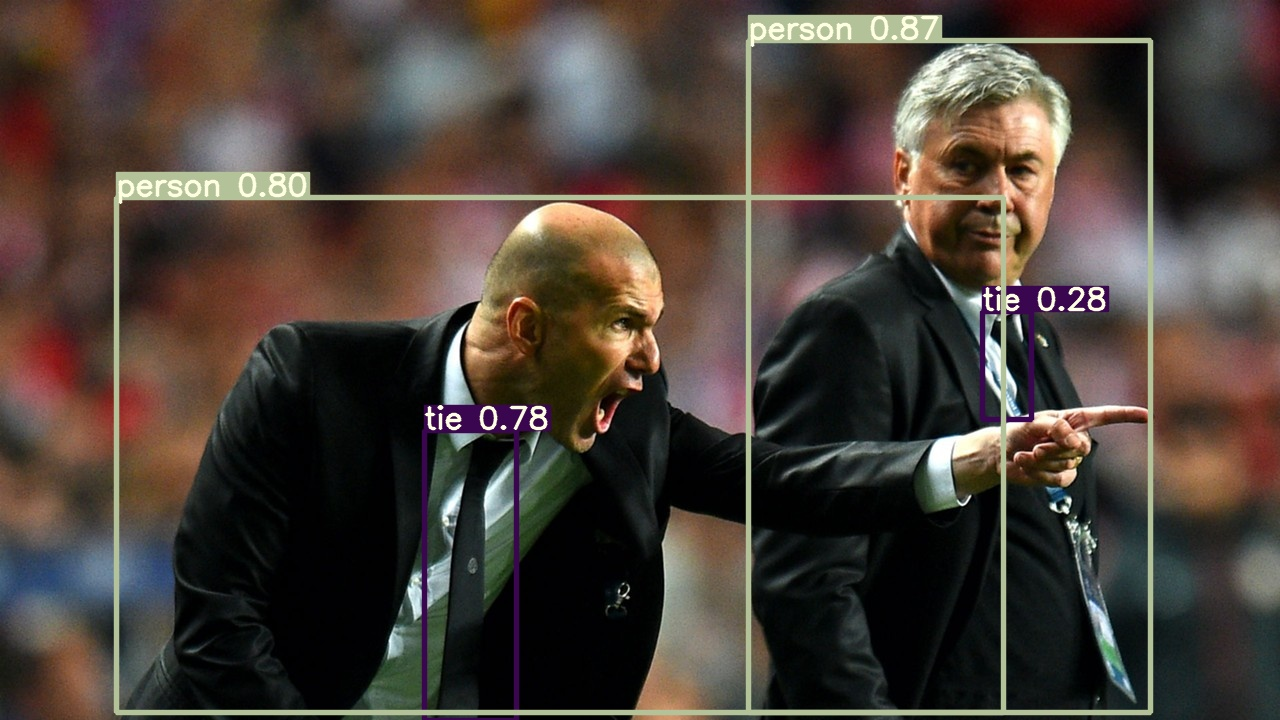

In [19]:
!python detect.py --weights yolov5l.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

## Pretrained Checkpoints:

| Model | AP<sup>val</sup> | AP<sup>test</sup> | AP<sub>50</sub> | Speed<sub>GPU</sub> | FPS<sub>GPU</sub> || params | FLOPS |
|---------- |------ |------ |------ | -------- | ------| ------ |------  |  :------: |
| [YOLOv5s](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 37.0     | 37.0     | 56.2     | **2.4ms** | **416** || 7.5M   | 13.2B
| [YOLOv5m](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 44.3     | 44.3     | 63.2     | 3.4ms     | 294     || 21.8M  | 39.4B
| [YOLOv5l](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 47.7     | 47.7     | 66.5     | 4.4ms     | 227     || 47.8M  | 88.1B
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | **49.2** | **49.2** | **67.7** | 6.9ms     | 145     || 89.0M  | 166.4B
| | | | | | || |
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0) + TTA|**50.8**| **50.8** | **68.9** | 25.5ms    | 39      || 89.0M  | 354.3B
| | | | | | || |
| [YOLOv3-SPP](https://github.com/ultralytics/yolov5/releases/tag/v3.0) | 45.6     | 45.5     | 65.2     | 4.5ms     | 222     || 63.0M  | 118.0B

# Selecting Models
In this notebok I'm using `v5s`. To select your prefered model just replace `--cfg models/yolov5s.yaml --weights yolov5s.pt` with the following command:
* `v5s` : `--cfg models/yolov5s.yaml --weights yolov5s.pt`
* `v5m` : `--cfg models/yolov5m.yaml --weights yolov5m.pt`
* `v5l` : `--cfg models/yolov5l.yaml --weights yolov5l.pt`
* `v5x` : `--cfg models/yolov5x.yaml --weights yolov5x.pt`

# Train

In [20]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
!WANDB_MODE="dryrun" python train.py --img 512 --batch 24 --epochs 35 --data /kaggle/working/siim-cov19.yaml --hyp /kaggle/input/yolov5-1-yaml/hyp.scratch.yaml --weights yolov5l.pt --cache

2021-06-30 07:39:49.113260: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B is disabled in this directory.  Run `wandb on` to enable cloud syncing.
Scanning '/kaggle/working/siim-cov19/labels/train' for images and labels... 5068 found, 0 missing, 1611 empty, 0 corrupted: 100%|██████████| 5068/5068 [00:01<00:00, 2763.21it/s]
Scanning '/kaggle/working/siim-cov19/labels/train.cache' for images and labels... 5068 found, 0 missing, 1611 empty, 0 corrupted: 100%|██████████| 5068/5068 [00:00<00:00, 9393165.12it/s]
Caching images (4.0GB): 100%|██████████| 5068/5068 [00:18<00:00, 272.09it/s]
Scanning '/kaggle/working/siim-cov19/labels/val' for images and labels... 1266 found, 0 missing, 429 empty, 0 corrupted: 100%|██████████| 1266/1266 [00:01<00:00, 1209.94it/s]
Scanning '/kaggle/working/siim-cov19/labels/val.cache' for images and labels... 1266 found, 0 missing, 

# Class Distribution

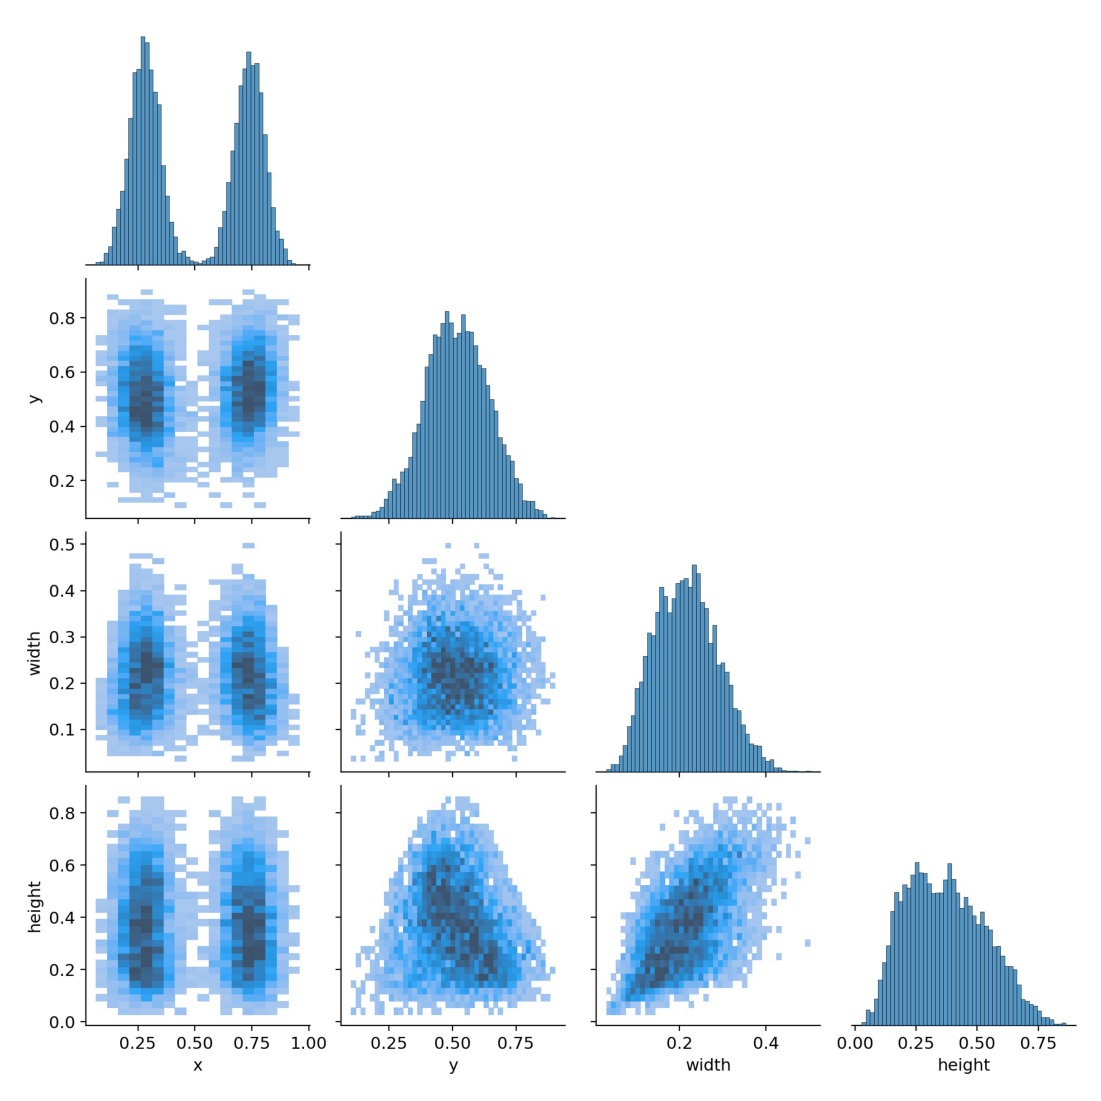

In [21]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

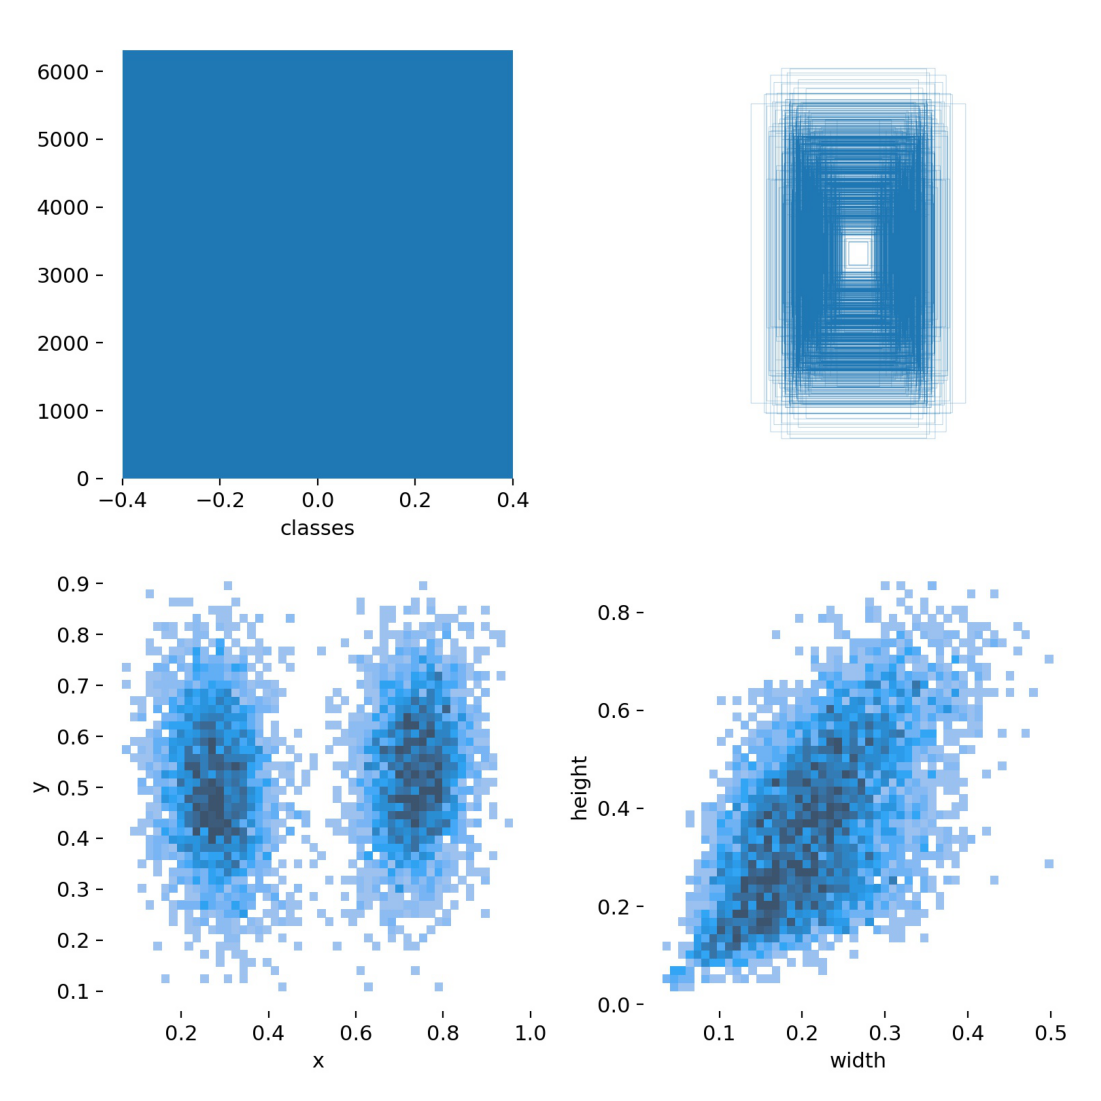

In [22]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

# Batch Image

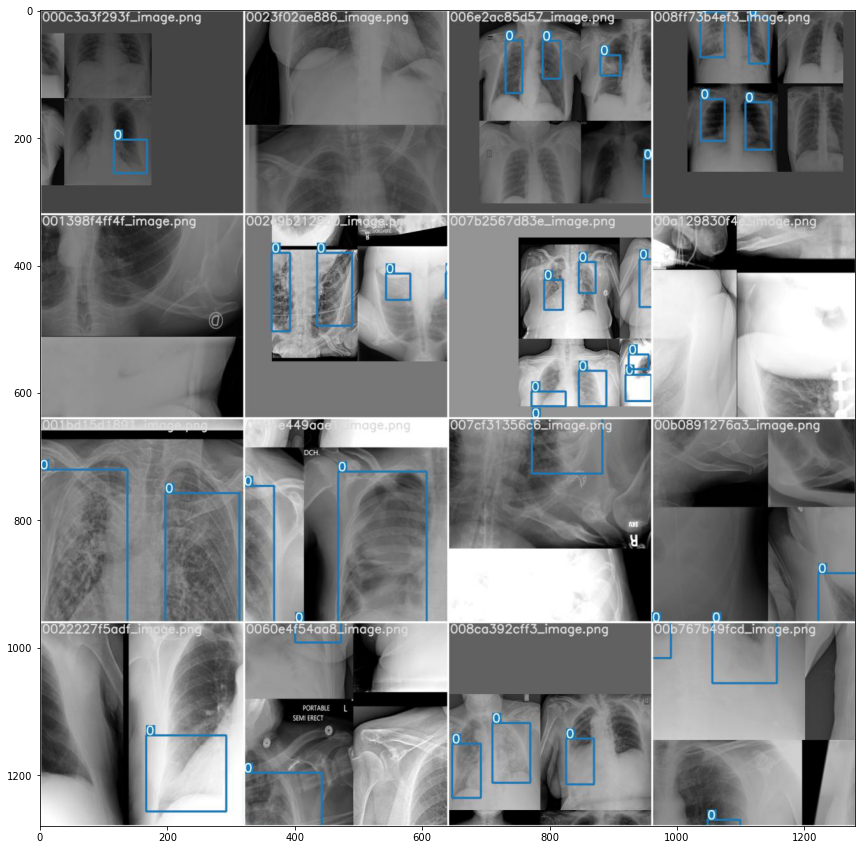

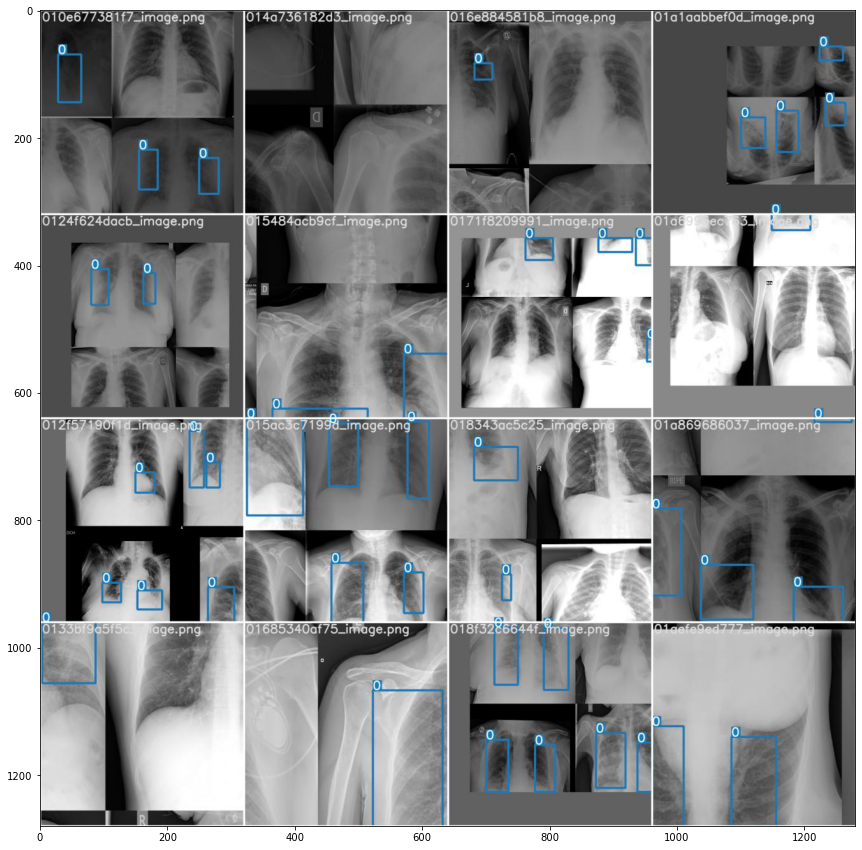

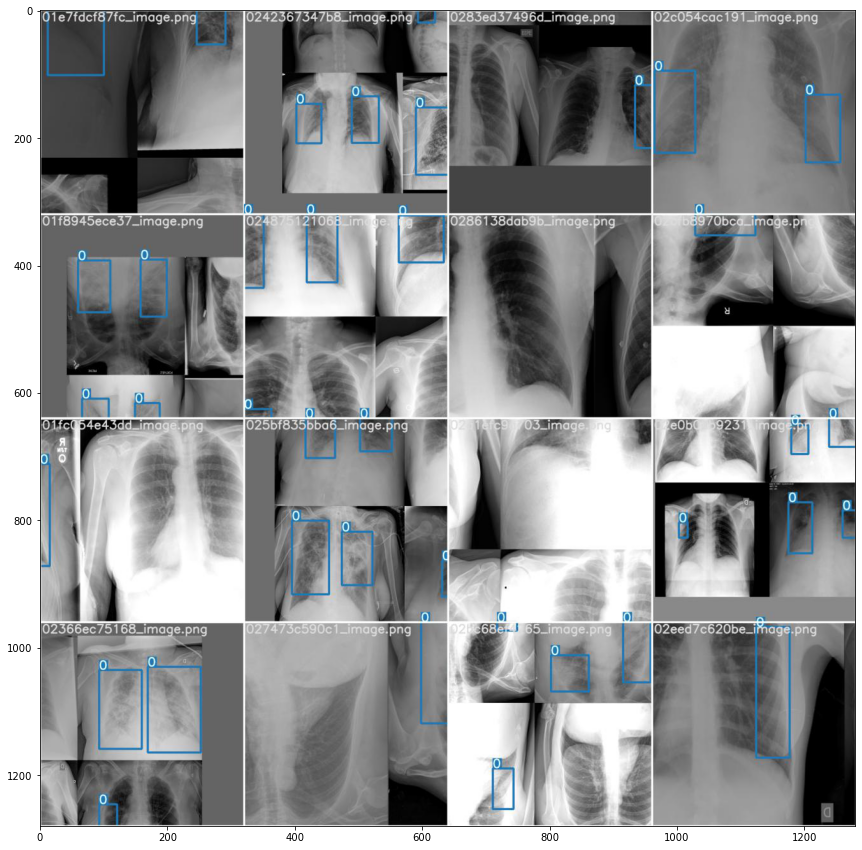

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch1.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

# GT Vs Pred

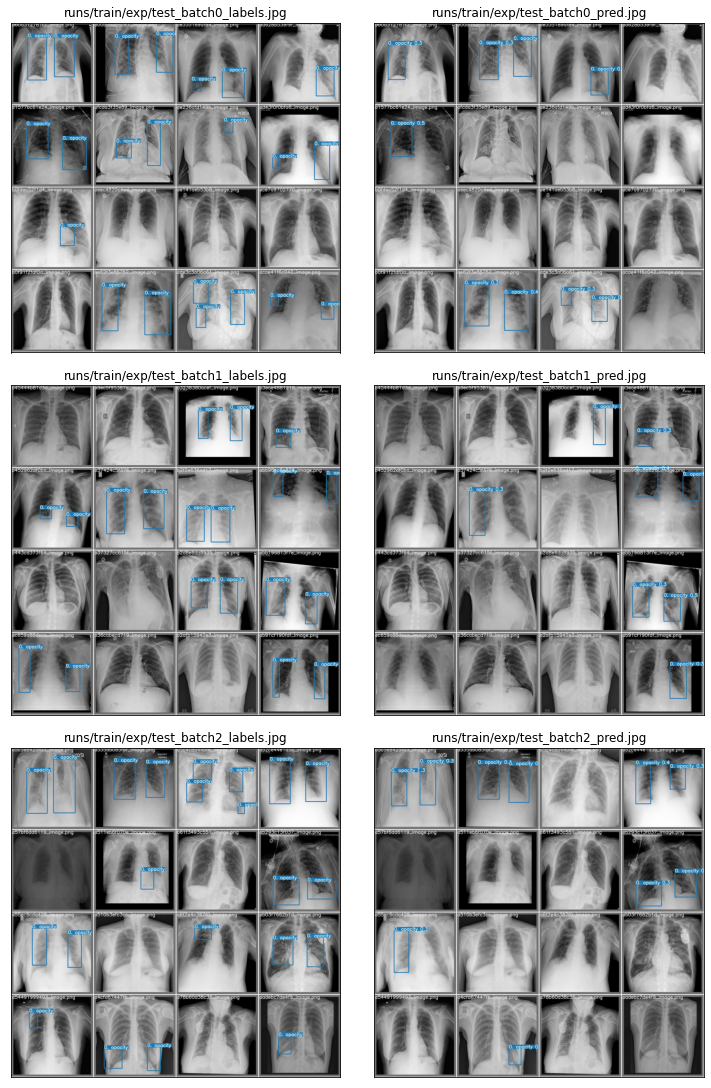

In [24]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/exp/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/test_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/test_batch{row}_pred.jpg', fontsize = 12)

# (Loss, Map) Vs Epoch

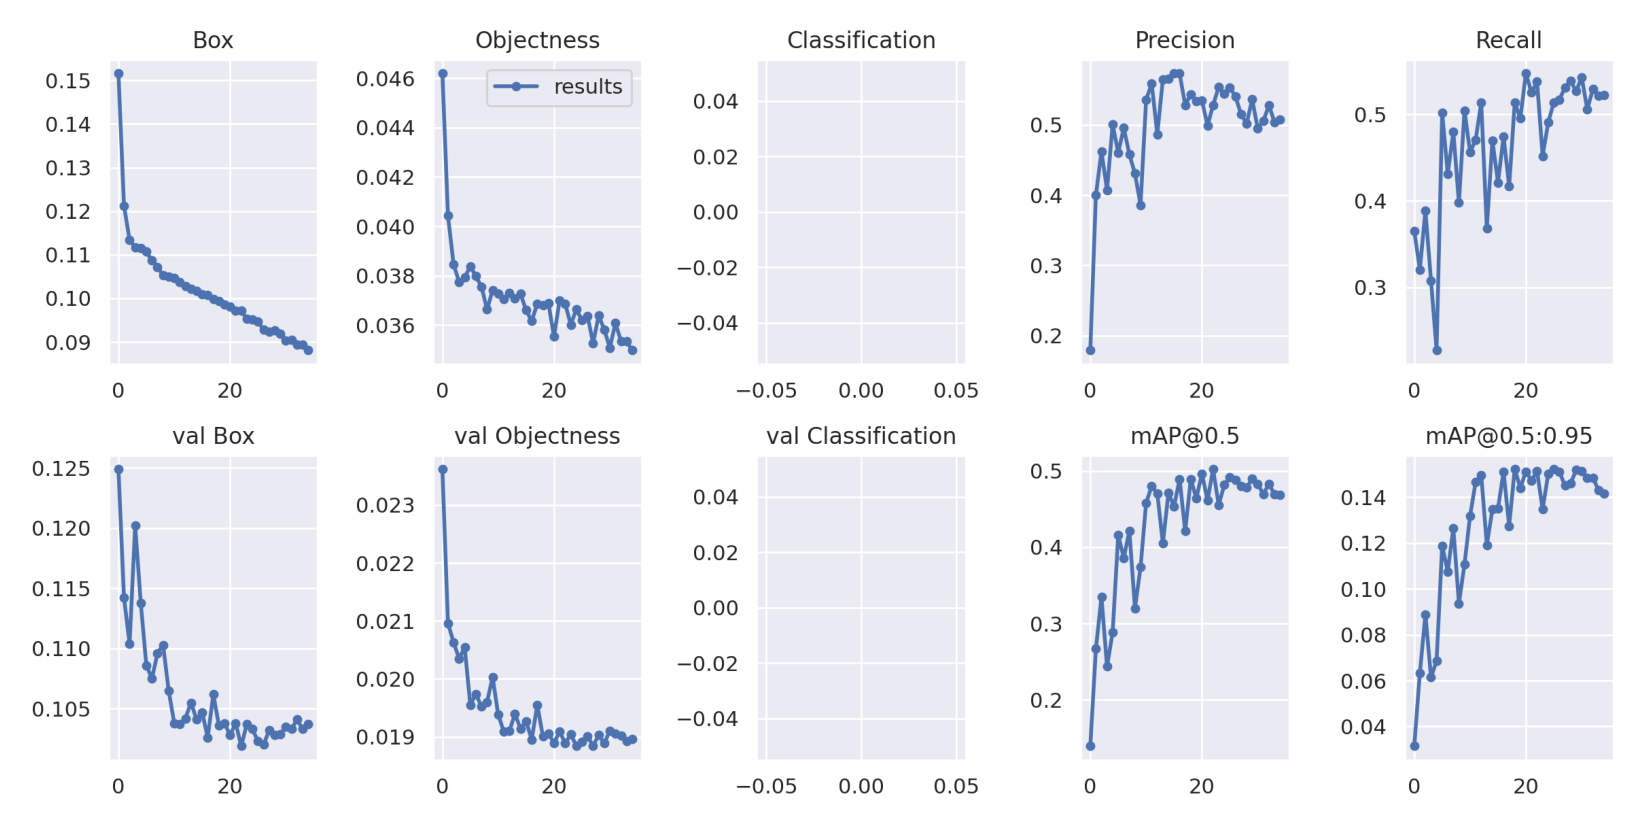

In [25]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

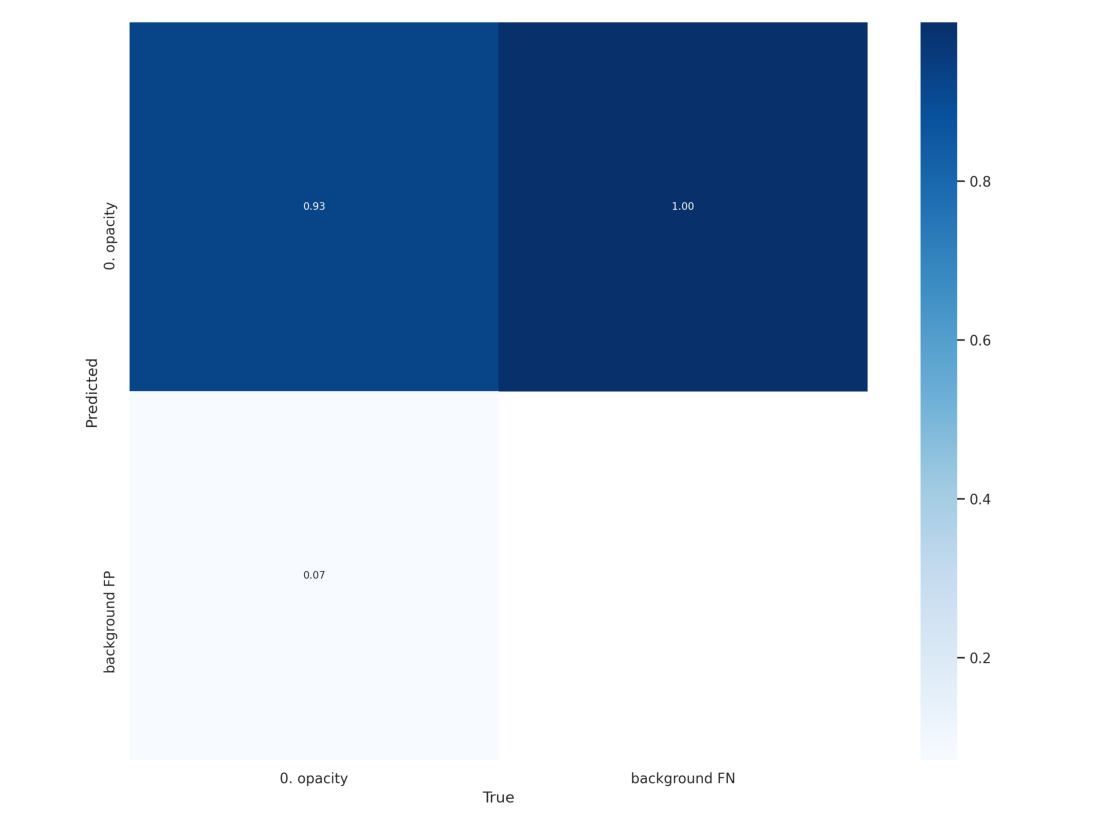

In [26]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Inference

In [27]:
!python detect.py --weights 'runs/train/exp/weights/best.pt'\
--img 512\
--conf 0.1\
--iou 0.5\
--source /kaggle/working/siim-cov19/images/val\
--exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=True, img_size=512, iou_thres=0.5, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/working/siim-cov19/images/val', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/1266 /kaggle/working/siim-cov19/images/val/000a312787f2_image.png: 512x512 2 0. opacitys, Done. (0.029s)
image 2/1266 /kaggle/working/siim-cov19/images/val/0012ff7358bc_image.png: 512x512 2 0. opacitys, Done. (0.028s)
image 3/1266 /kaggle/working/siim-cov19/images/val/00326161e51e_image.png: 512x512 2 0. opacitys, Done. (0.028s)
image 4/1266 /kaggle/working/siim-cov19/images/val/0049814626c8_image.png: 512x512 2 0. opacitys, Done. (0.028s)
image 5/1266 /kaggle/working/siim-cov19/images/val/004cbd797cd1_image.png: 512x512 2 0. opacitys, Done. (0.027s)
image 6/1266 /kaggle/working/siim-cov19/images/val/00b8180bd3a8_image.png: 512x512 2 0. opacitys,

# Inference Plot

100%|██████████| 16/16 [00:00<00:00, 133.52it/s]


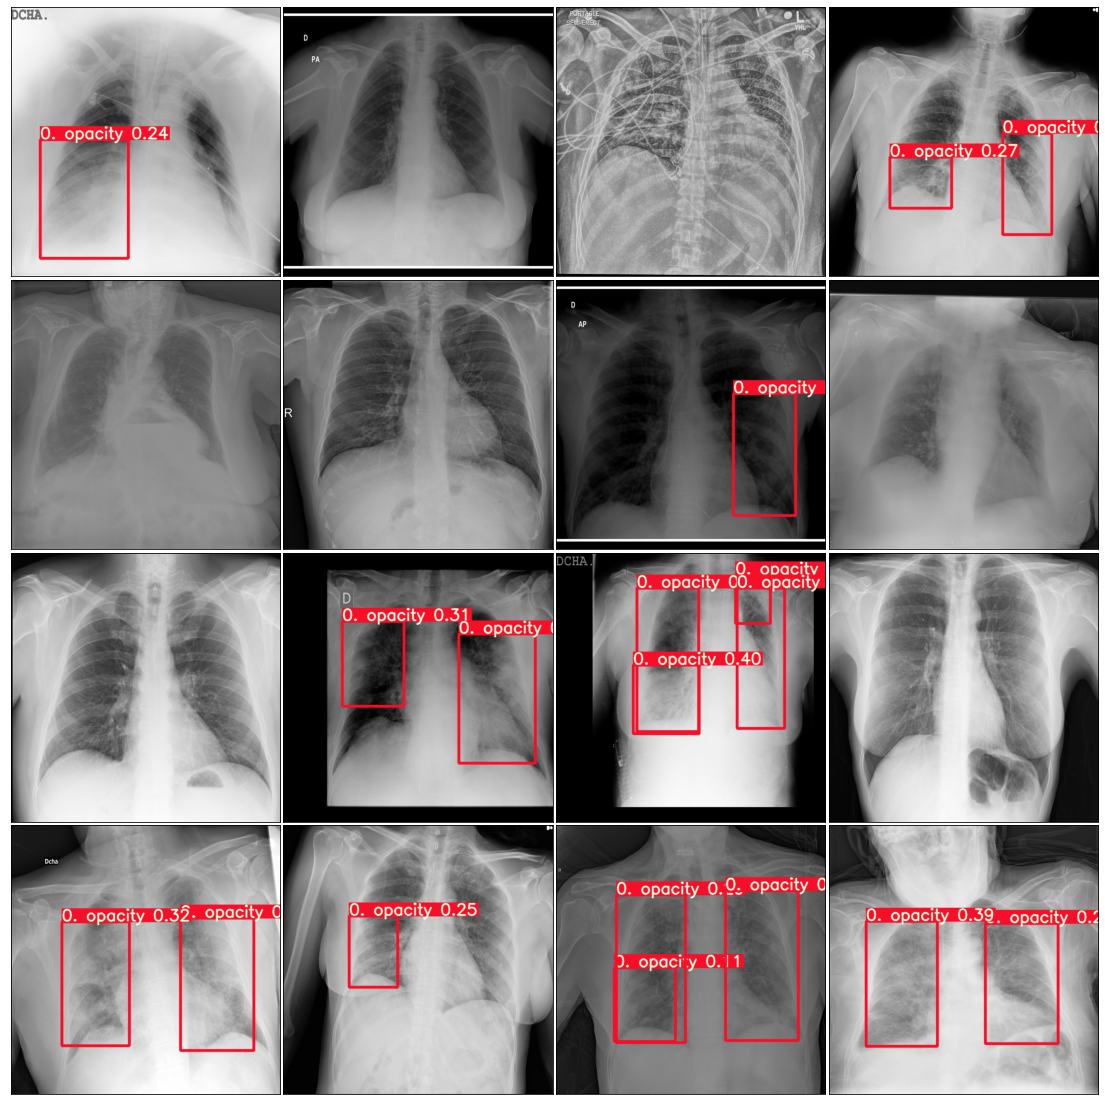

100%|██████████| 16/16 [00:00<00:00, 132.54it/s]


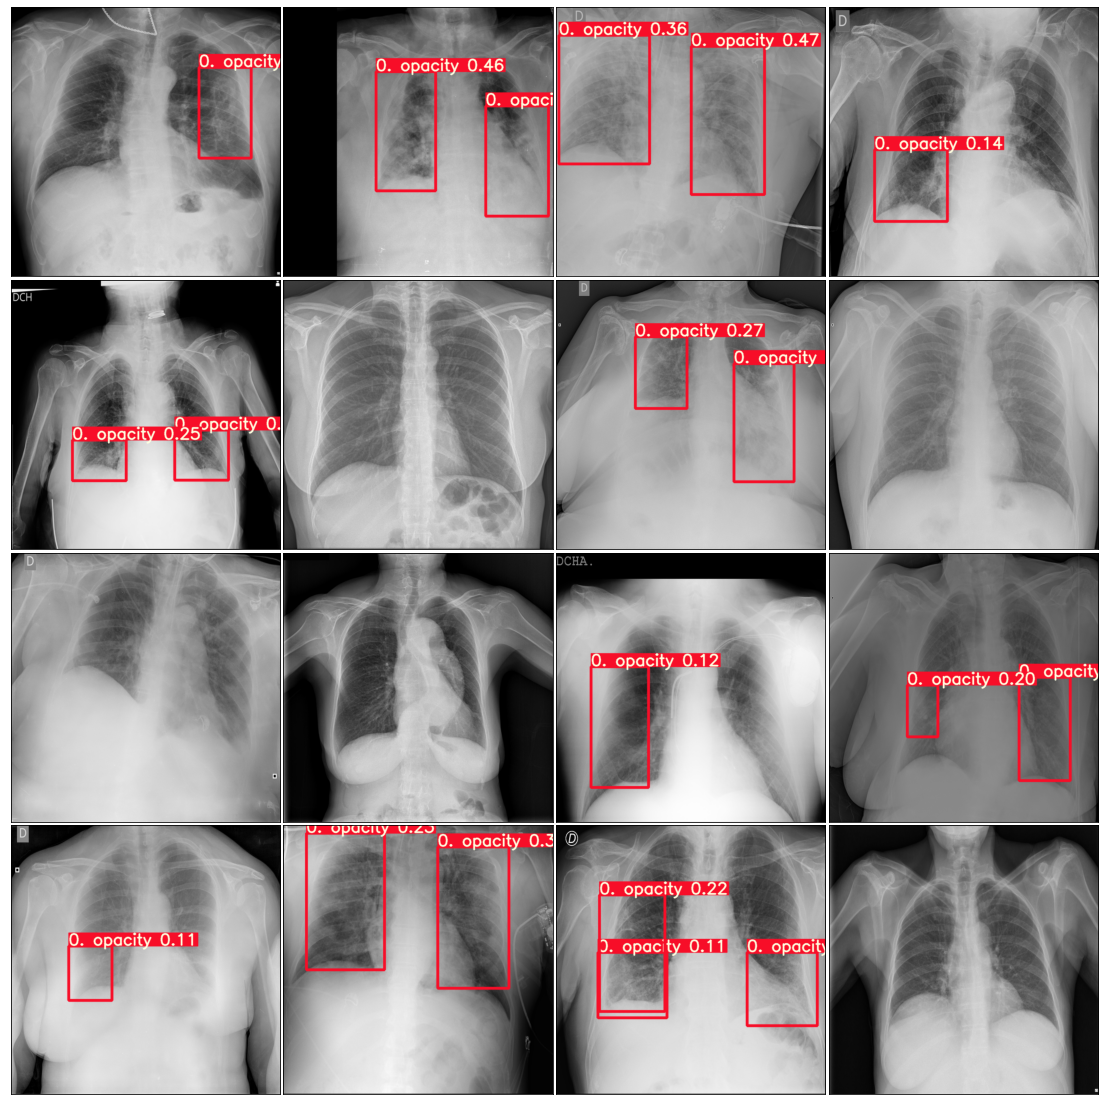

100%|██████████| 16/16 [00:00<00:00, 134.46it/s]


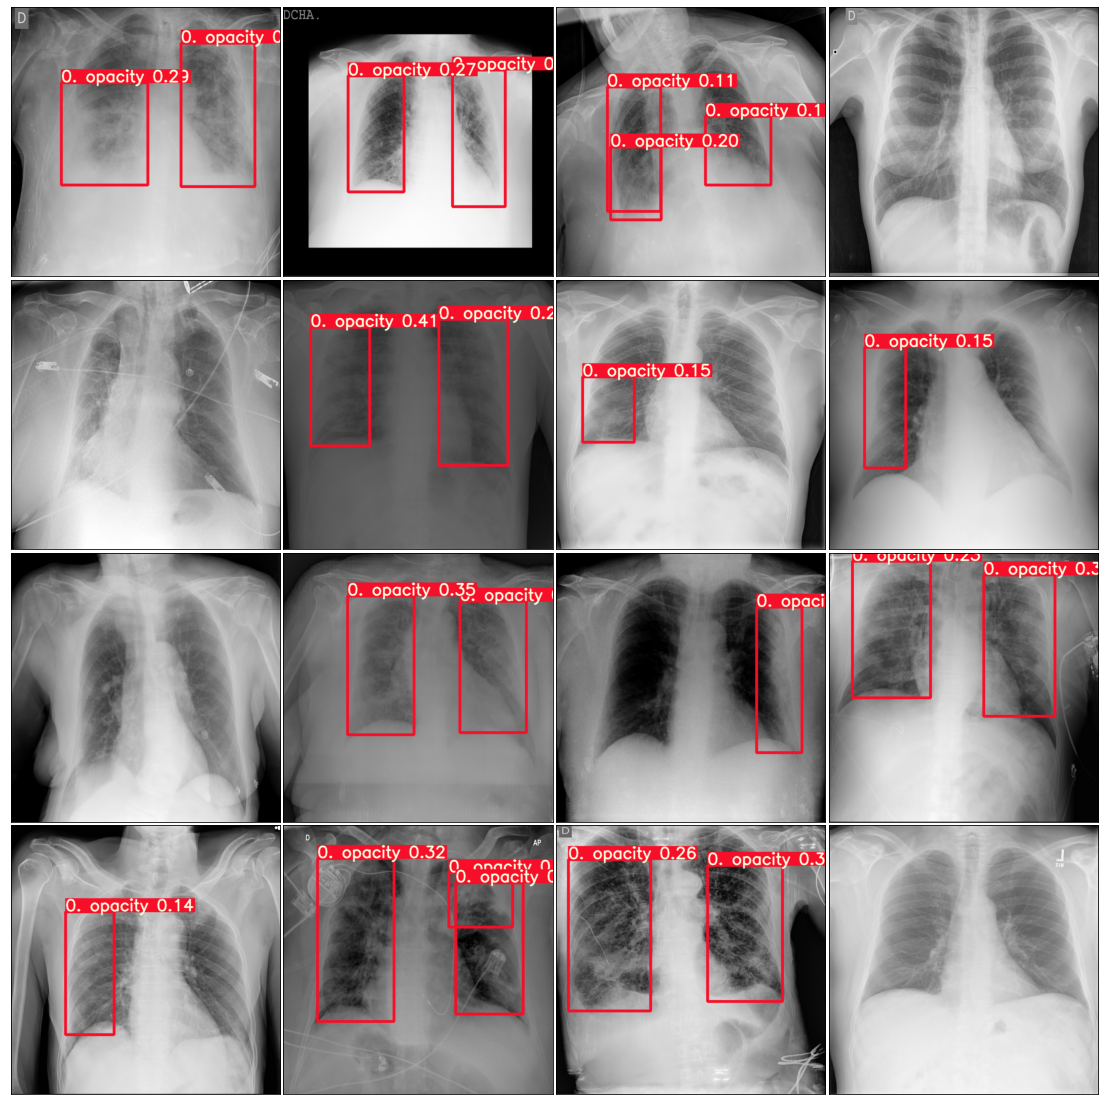

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
shutil.rmtree('/kaggle/working/siim-cov19')
shutil.rmtree('runs/detect')
for file in (glob('runs/train/exp/**/*.png', recursive = True)+glob('runs/train/exp/**/*.jpg', recursive = True)):
    os.remove(file)